In [3]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt

from dynamics.Aircraft2D import Aircraft2DPointMass
from aerodynamics.SimpleAircraft2D import ThinAirfoilModel
from aerosandbox.numpy.integrate_discrete import integrate_discrete_squared_curvature as int_desc

In [4]:
# initialize the optimization problem class
opti = asb.Opti()

# set up the problem as a constant dt problem, initialize different opti.variable instances for each of the 'free' variables
dt = .1
time = np.arange(0,10,dt)
N = np.length(time)
dyn = Aircraft2DPointMass(
    mass = 9.54, # kg # vehicle mass is encoded in the point mass info
    Iyy = 1.83, # kg-m^2 # vehicle rolling inertia contained in point mass info
    x_earth = opti.variable(init_guess=1*np.linspace(1,100,N),upper_bound=1e4,lower_bound=-1),  # [m] earth x-position
    z_earth = opti.variable(init_guess=1*np.linspace(1,100,N),upper_bound=1e4,lower_bound=-1e4), # [m] # earth z-position (altitude)
    w_body = opti.variable(init_guess=0*np.linspace(1,30,N),upper_bound=2,lower_bound=-2), # [m/s] z-component body velocity
    u_body = opti.variable(init_guess=1*np.linspace(1,30,N),upper_bound=30,lower_bound=0), # [m/s] x-component body velocity
    pitch = opti.variable(init_guess=0*np.linspace(1,100,N),upper_bound=30,lower_bound=-30),  # [deg] pitch of the aircraft w.r.t. x-axis in the earth frame,
    pitch_rate = opti.variable(init_guess=np.zeros((N,)), upper_bound=20,lower_bound=-20),
    flap_deflection= 1 * np.ones(time.shape), # [deg] flap deflection angle (+ down)
    elevator_deflection = opti.variable(init_guess=0*np.linspace(1,100,N),upper_bound=10,lower_bound=-10), # [deg] horizontal tail deflection angle (+ down)
    throttle_position = opti.variable(init_guess=0*np.ones(time.shape),upper_bound=1,lower_bound=0) # [-] throttle position from 0-1
    # delta_T=np.zeros(time.shape)
)

dyn.WindModel.setParameters(model_name='gaussian1D', **{'STD':20,'center':75,'MaxGustVelocity':-5,'axis':'z'})

# encode aircraft dimensional information into point mass class
dyn.Span = 3.05
dyn.ChordMean = 0.38
dyn.TailSpan = 1.27
dyn.TailChordMean = 0.25
dyn.Area = 1.09
dyn.TailArea = 0.2

In [5]:
# Initialize the dynamics model (for exactly how it works, enter the ThinAirfoilModel() class file
amodel = ThinAirfoilModel()

# generate the Lift, drag, and moment dyamics equations from the aeromodel, 
L,D,M = amodel.getForcesAndMoments(dyn)
cl,cd,cm = amodel.fullDynamicsModel(dyn)
Thrust = amodel.thrustModel(dyn) # thrust separately to simplify for now

#=================================================
# add constraints to the constraint list

# aero forces added in aero frame
dyn.add_force(D,L,from_axes='wind')
dyn.add_moment(M)

# non-aero forces added in the easiest frame of reference to do out the math
dyn.add_force(0,dyn.Mass*9.81,from_axes='earth')
#dyn.add_force(Thrust,0,from_axes='body')
dyn.add_force(Thrust,0,from_axes='body')
dyn.add_moment(Thrust * 0.1)

In [6]:
# start adding constraints. This section contains general contraints (i.e. forward motion, must not be in contact with ground etc) 

# general forward motion and ground boundayr conditions
opti.subject_to([
    dyn.BodyXVelocity >= 0,
    dyn.Altitude >= 0,
    dyn.EarthXPosition >=0,
    dyn.Airspeed >= 5
])



# aero model limitations on AoA 
opti.subject_to([
    dyn.Alpha**2 <=144
])

# ===========================================================
# set simulation - specific limits on control variables

# get rates for directly-controlled state/control variables
throttle_rate = np.diff(dyn.ThrottlePosition) / np.diff(time)
tail_rate = np.diff(dyn.ElevatorPosition) / np.diff(time)

# set constraints
opti.subject_to([
    # flap_rate >= -2,
    # flap_rate <= 2,
    tail_rate**2 <= 10,
    dyn.ElevatorPosition**2 <= 100 ,
    dyn.PitchRate**2 <= 225,
    dyn.ThrottlePosition >= 0,
    dyn.ThrottlePosition < 1, 
    throttle_rate**2 < 0.2,
])

[MX(fabs(opti0_lam_g_22)),
 MX(fabs(opti0_lam_g_23)),
 MX(fabs(opti0_lam_g_24)),
 MX(fabs(opti0_lam_g_25)),
 MX(fabs(opti0_lam_g_26)),
 MX(fabs(opti0_lam_g_27))]

In [7]:
# problem specific dynamics constraints including start-end boundary conditions

# start constraints, in general must start at a relatively steady-level flight condition
opti.subject_to([
    dyn.EarthXPosition[0] == 0,  # starting position arbitrarily 0
    dyn.Altitude[0] == 200,  # starting Altitude of 2km (~180 ft),
    # dyn.DeltaThrottle[0] ==0.01, # throttle starts near 0
    
])

# end constraints -- level flight

# cruise constraints
opti.subject_to([
    (dyn.Altitude[1:]-dyn.Altitude[0])**2 < 20,
    (dyn.Airspeed[1:] - dyn.Airspeed[0])**2 < 1,
    dyn.glide_slope**2 < 0.8,
    (dyn.Alpha[1:]-dyn.Alpha[0]) ** 2 <1,
    dyn.Altitude[-1]-dyn.Altitude[0] >= 0
])
curv = int_desc(dyn.ElevatorPosition/25,time) + int_desc(dyn.ThrottlePosition,time)

# cost function for the optimizer to work against
opti.minimize(1e-2*np.sum(curv) + np.mean(cd) + 5*np.sum(dyn.ElevatorPosition**2) + np.sum(dyn.ThrottlePosition**2))

# send constraints to the opti instance
dyn.constrain_derivatives(opti,time,method='cubic')

In [8]:
# run the optimizaiton problem, if it fails return the last solution. The optimizer is very sensitive to boundary constraints, so it will sometimes fail even though a solution is nearly correct so it is reasonable to inspect those solutions sometimes
try:
    sol = opti.solve(max_iter=2000,behavior_on_failure="return_last",detect_simple_bounds=True)
    dyn = sol(dyn)
    x_e = dyn.EarthXPosition
    z_e = dyn.Altitude
    u = dyn.BodyXVelocity
    w = dyn.BodyZVelocity
    time = sol(time)
    
except RuntimeError:
    dyn = sol(dyn)
    x_e = dyn.EarthXPosition
    z_e = dyn.Altitude
    u = dyn.BodyXVelocity
    w = dyn.BodyZVelocity
    time = sol(time)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    10240
Number of nonzeros in inequality constraint Jacobian.:     3180
Number of nonzeros in Lagrangian Hessian.............:     3570

Total number of variables............................:      798
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      798
                     variables with only upper bounds:        0
Total number of equality constraints.................:      594
Total number of inequality constraints...............:      996
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      895

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0774818e-01 3.98e+04 1.74e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

/Users/trevorlong/.pyenv/versions/3.12.7/envs/venv_trajopt/lib/python3.12/site-packages/aerosandbox/optimization/opti.py:728: UserWarning: Optimization failed. Returning last solution.
  warnings.warn("Optimization failed. Returning last solution.")


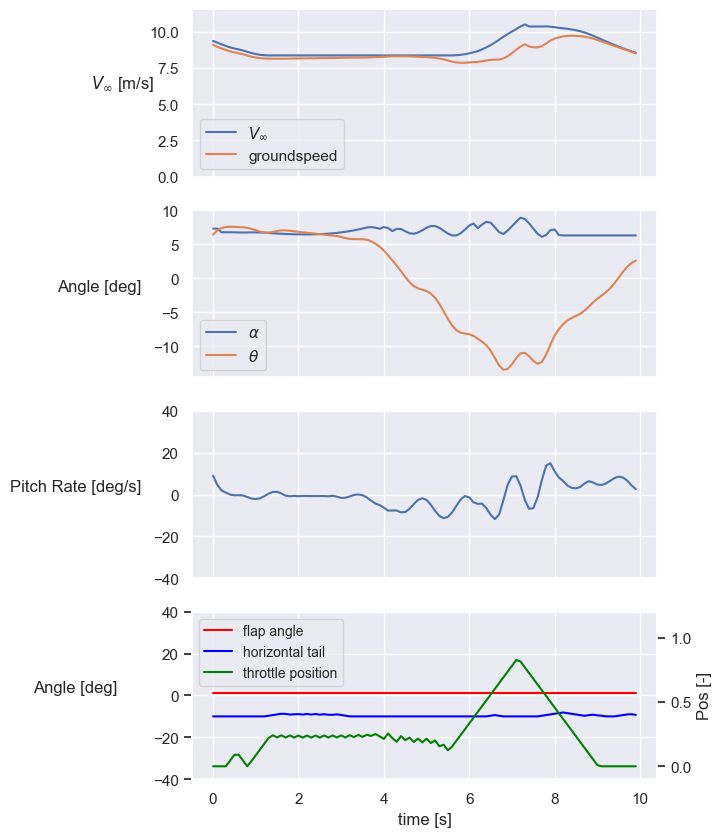

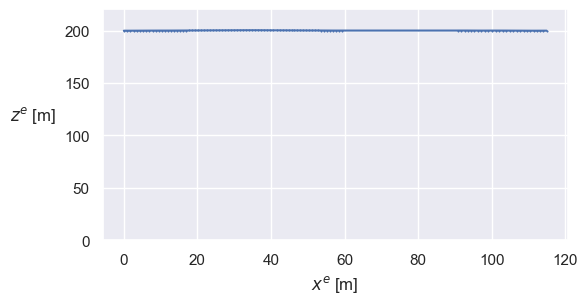

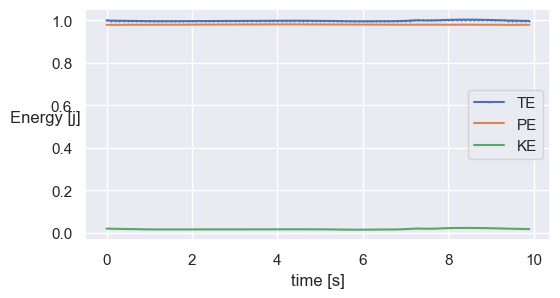

In [7]:
# everything from here on is plotting and plotting to debug and so is not yet totally cleaned. 

from dynamics.visualization import visualizeRun2D
fig_dict = visualizeRun2D(time,dyn)

In [9]:
dyn.__dict__


{'Mass': 9.54,
 'Iyy': 1.83,
 'EarthXPosition': array([ 0.00000000e+00, -3.82860219e-07, -3.31271482e-07, -2.84760037e-07,
        -9.05848534e-09,  1.23380592e+00,  2.45695392e+00,  1.71563810e-07,
         7.24116975e-01,  1.92739033e+00,  3.12814583e+00,  4.32818613e+00,
         3.68492292e+00,  2.48986280e+00,  2.23368432e+00,  1.12600021e+00,
         6.00418360e-06,  3.90933444e-01,  1.59068907e+00,  2.79059894e+00,
         3.99084728e+00,  5.19149562e+00,  6.39259625e+00,  7.59417899e+00,
         8.79628798e+00,  9.99897767e+00,  1.12023253e+01,  1.24064291e+01,
         1.36114124e+01,  1.48174236e+01,  1.60246378e+01,  1.72332580e+01,
         1.84435167e+01,  1.96556693e+01,  2.08700390e+01,  2.20869390e+01,
         2.33067276e+01,  2.45298274e+01,  2.57566728e+01,  2.69877516e+01,
         2.82235770e+01,  2.94645644e+01,  3.07114133e+01,  3.19648360e+01,
         3.32252264e+01,  3.44930275e+01,  3.57690455e+01,  3.70551590e+01,
         3.83526616e+01,  3.96607488e+01,

In [8]:
L,D,M = amodel.getForcesAndMoments(dyn)
cl,cd,cm = amodel.fullDynamicsModel(dyn)
clt,cdt,cmt = amodel.tailDynamicsModel(dyn)
clw,cdw,cmw = amodel.wingDynamicsModel(dyn)
thrust = amodel.thrustModel(dyn)

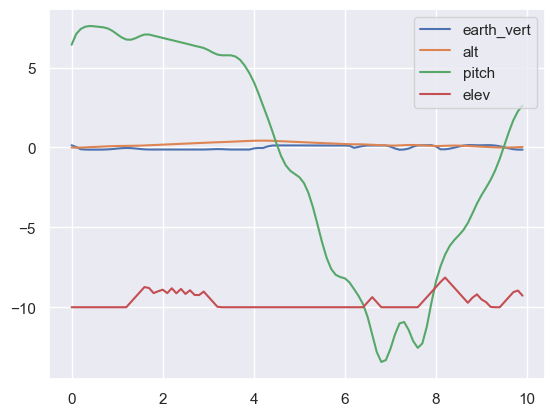

In [9]:



plt.plot(time,dyn.EarthZVelocity,label='earth_vert')
plt.plot(time,dyn.Altitude-dyn.Altitude[0],label='alt')
plt.plot(time,dyn.Pitch,label='pitch')
plt.plot(time,dyn.ElevatorPosition,label='elev')


plt.legend()

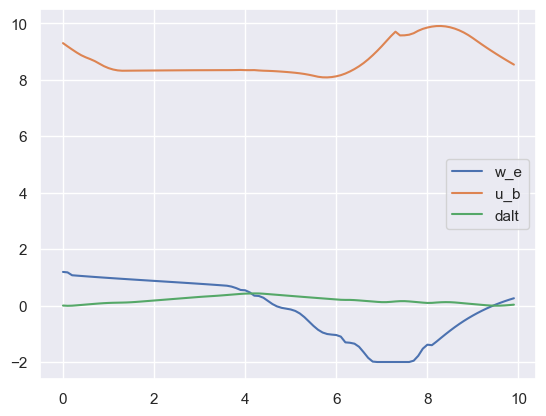

In [10]:
  
plt.plot(time,dyn.BodyZVelocity,label='w_e')
plt.plot(time,dyn.BodyXVelocity,label='u_b')
plt.plot(time,dyn.Altitude-dyn.Altitude[0],label='dalt')
plt.legend()

In [2]:
dyn

NameError: name 'dyn' is not defined

AttributeError: 'Aircraft2DPointMass' object has no attribute 'DeltaElevator'

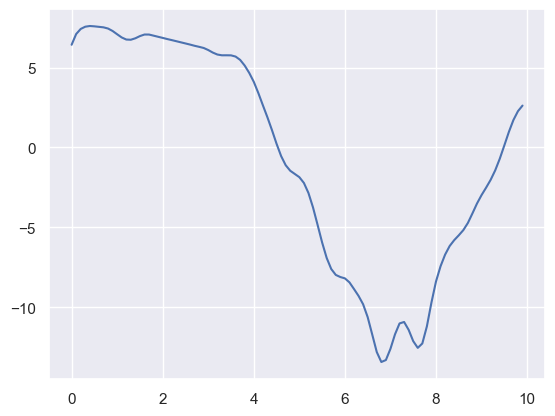

In [12]:
plt.plot(time,dyn.Pitch)
plt.plot(time,dyn.DeltaElevator)


plt.legend()

In [ ]:
plt.plot(time,dyn.Fx_b,label='xforce')
plt.plot(time,dyn.Pitch,label='pitch')
plt.plot(time,thrust,label='thrust-force')
fx,fz = dyn.convert_axes(D,0,from_axes='wind',to_axes='body')
plt.plot(time,fx  ,label='drag force')
plt.plot(time,dyn.a_x,label='ax')

plt.legend()


In [ ]:

plt.plot(time,dyn.Airspeed*np.cosd(dyn.Pitch),label='u_e')
# plt.plot(time,dyn.speed*np.sind(dyn.Pitch),label='w_e')
plt.plot(time,dyn.w_e,label='computed w_e')
plt.plot(time,dyn.Pitch,label='pitch')

plt.legend()

In [ ]:
plt.plot(clt)
plt.plot(dyn.alpha)

In [ ]:
plt.figure()

plt.plot(time,dyn.KE-dyn.KE[0],label='KE')
plt.plot(time,dyn.PE-dyn.PE[0],label='PE')
plt.plot(time,dyn.TE-dyn.TE[0],label='TE')
plt.legend()

In [ ]:
dyn.z_e[-1]

In [ ]:
dyn.z_e[0]

In [ ]:
plt.plot(time,cmw)
plt.plot(time,clt,label='clt')
plt.plot(time,cm,label='cm',color='green')
plt.plot(time,dyn.My_b,label='my')
plt.plot(time,dyn.Pitch/100,label='Pitch')

plt.legend()


In [ ]:
plt.plot(dyn.delta_T)

In [ ]:
 np.array([dyn.Pitch,dyn.dtheta]).T

In [ ]:
dyn.BodyXVelocity

In [ ]:
dyn.My_b

In [ ]:
dyn.Altitude

In [1]:
dyn

NameError: name 'dyn' is not defined